# Prueba selección de nubes

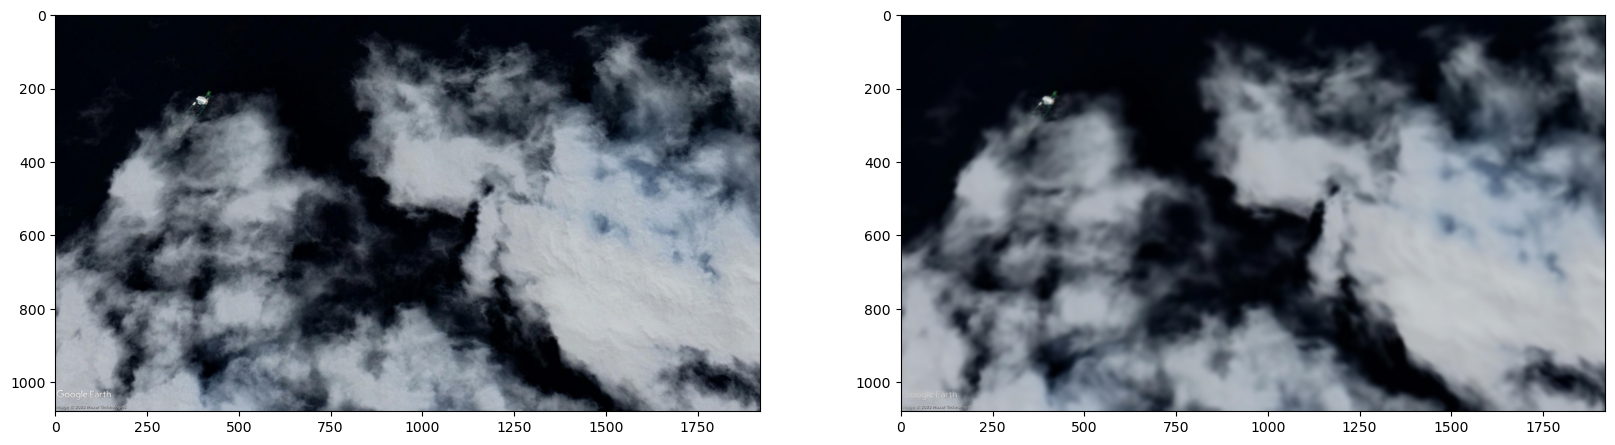

In [7]:
# importing the numpy library  
import numpy as np  
# importing the openCV library  
import cv2  
# importing the pyplot for visualizing the image  
from matplotlib import pyplot as plt  
  
# reading image using the cv2.imread() function  
img = cv2.imread( 'Imágenes TFM/cloud/cloud_13_3_2017_846.jpg' )  
  
# denoising the image using the cv2.fastNlMeansDenoising() function  
dst = cv2.fastNlMeansDenoising( img, None, 15, 100, 21 )  

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
  
# visualizing the image and comparing noisy image and image after denoising
plt.figure(figsize=(20,16))
plt.subplot( 121 )  
plt.imshow( img )  
plt.subplot( 122 )  
plt.imshow( dst )  
plt.show() 

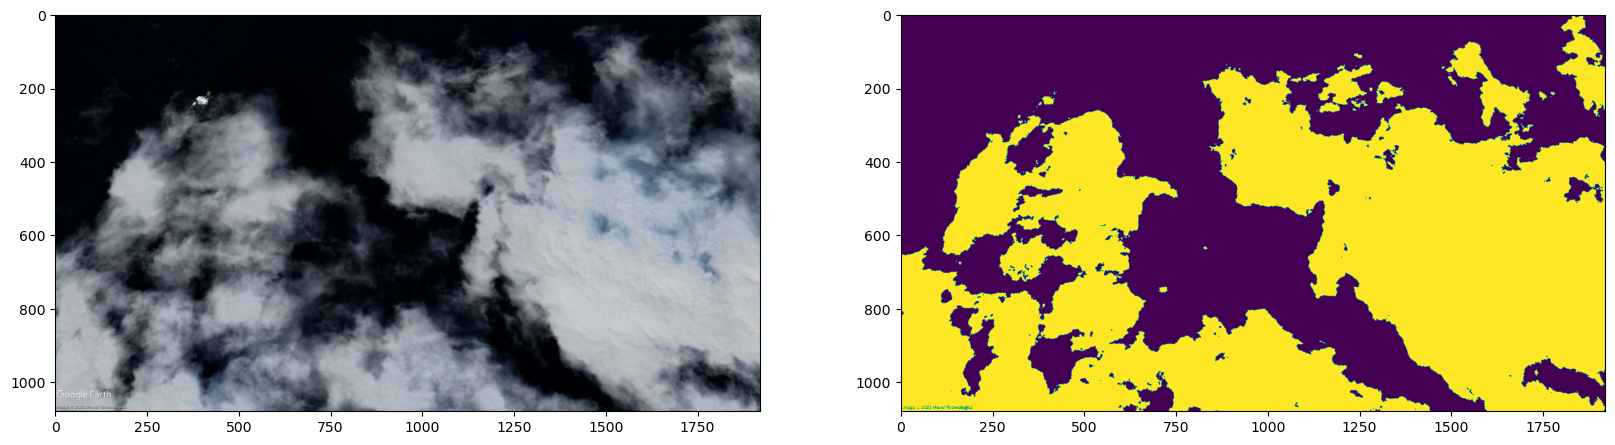

In [7]:
grayscaleImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert the BGR image to HSV:
hsvImage = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# HSV colors for white 
lowerValues = np.array([180, 18, 255])
upperValues = np.array([0, 0, 231])

# Get binary mask of the blue ink:
bluepenMask = cv2.inRange(hsvImage, lowerValues, upperValues)
# Use a little bit of morphology to clean the mask:
# Set kernel (structuring element) size:
kernelSize = 3
# Set morph operation iterations:
opIterations = 1
# Get the structuring element:
morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))
# Perform closing:
bluepenMask = cv2.morphologyEx(bluepenMask, cv2.MORPH_CLOSE, morphKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

# Add the white mask to the grayscale image:
colorMask = cv2.add(grayscaleImage, bluepenMask)
_, binaryImage = cv2.threshold(colorMask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#cv2.imwrite('bwimage.jpg',binaryImage)
thresh, im_bw = cv2.threshold(binaryImage, 210, 230, cv2.THRESH_BINARY)
kernel = np.ones((1, 1), np.uint8)
imgfinal = cv2.dilate(im_bw, kernel=kernel, iterations=1)

plt.figure(figsize=(20,16))
plt.subplot( 121 )  
plt.imshow( img )  
plt.subplot( 122 )  
plt.imshow( imgfinal )  
plt.show() 

# Tratamiento Glint

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


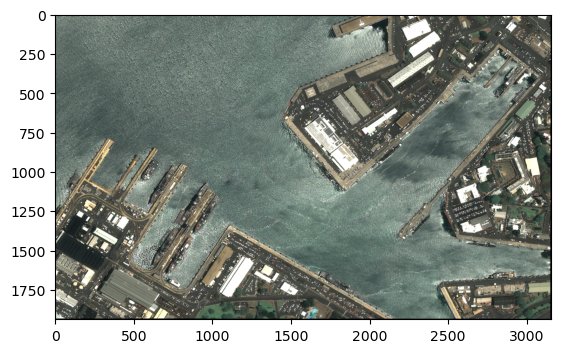

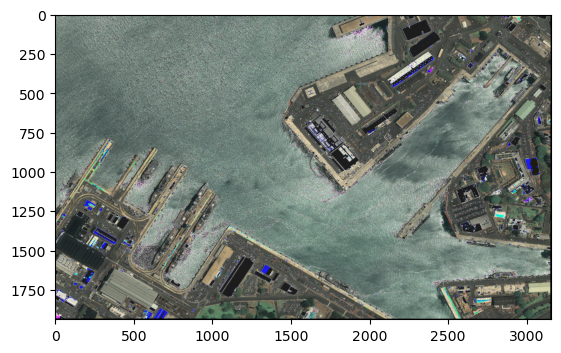

In [19]:
import numpy as np

def lyzenga_correction_simp(image, theta_s, theta_v, phi_s, phi_v, band):
    """
    Realiza la corrección de glint en una imagen utilizando el modelo de Lyzenga.
    
    Parámetros:
        image (numpy.ndarray): Matriz que representa la imagen original.
        theta_s (float): Ángulo solar zenital en grados.
        theta_v (float): Ángulo de vista zenital en grados.
        phi_s (float): Ángulo solar azimutal en grados.
        phi_v (float): Ángulo de vista azimutal en grados.
        
    Retorna:
        numpy.ndarray: La imagen corregida de glint.
    """
    # Conversión de grados a radianes
    theta_s_rad = np.radians(theta_s)
    theta_v_rad = np.radians(theta_v)
    phi_s_rad = np.radians(phi_s)
    phi_v_rad = np.radians(phi_v)
    
    # Cálculo de la corrección de glint utilizando el modelo de Lyzenga
    glint_correction = (np.cos(theta_s_rad) * np.cos(theta_v_rad) +
                        np.sin(theta_s_rad) * np.sin(theta_v_rad) *
                        np.cos(phi_v_rad - phi_s_rad))
        
    # Aplicar la corrección de glint a la imagen
    corrected_image = image / glint_correction
    
    return corrected_image

# Ejemplo de uso:
# Supongamos que tienes una imagen representada como una matriz numpy llamada "imagen_original"
# y tienes los valores de ángulos theta_s, theta_v, phi_s y phi_v.

ruta_imagen = './mosaic.tif'

with rasterio.open(ruta_imagen) as src:
    R = src.read(1)
    G = src.read(2)
    B = src.read(3)
img = np.stack((R, G, B), axis=-1)

phi_s = 107.60673744828289
phi_v = 180.726531670275
theta_s = 23.497281442704573
theta_v = 21.057140048073904

imagen_corregida_lyzenga = lyzenga_correction_simp(img, theta_s, theta_v, phi_s, phi_v,2)

#imagen_corregida = np.stack((R_corregida, G_corregida, B_corregida), axis=-1)
#img = np.stack((R, G, B), axis=-1)
#img_t = np.transpose(img, (1, 2, 0))

plt.imshow(img.astype(np.uint8))
plt.show()

plt.imshow(imagen_corregida_lyzenga.astype(np.uint8))
plt.show()


In [13]:
imagen_corregida.astype(np.uint8).shape

(1938, 3156, 3)

In [14]:
import matplotlib.image

matplotlib.image.imsave('noglint.tiff', imagen_corregida.astype(np.uint8))

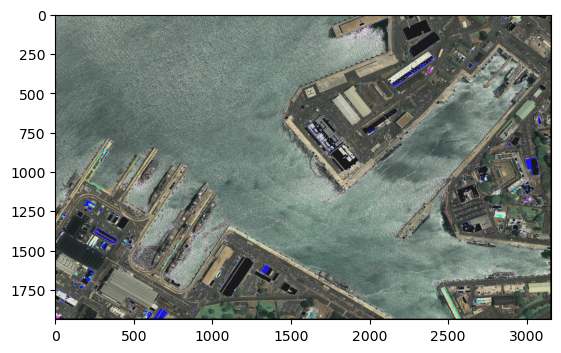

In [20]:
import numpy as np

def gordon_wang_correction_simp(image, sun_elevation, sensor_zenith, sensor_azimuth):
    """
    Realiza una corrección de glint utilizando el modelo de Gordon y Wang.
    
    Parámetros:
        image (numpy.ndarray): Matriz que representa la imagen original.
        sun_elevation (float): Ángulo de elevación solar en grados.
        sensor_zenith (float): Ángulo zenital del sensor en grados.
        sensor_azimuth (float): Ángulo azimutal del sensor en grados.
        
    Retorna:
        numpy.ndarray: La imagen corregida de glint.
    """
    # Conversión de grados a radianes
    sun_elevation_rad = np.radians(sun_elevation)
    sensor_zenith_rad = np.radians(sensor_zenith)
    sensor_azimuth_rad = np.radians(sensor_azimuth)
    
    # Parámetros del modelo de Gordon y Wang
    K = 0.2  # Constante empírica
    
    # Cálculo de la corrección de glint
    cos_theta = np.cos(sensor_zenith_rad)
    cos_phi = np.cos(sensor_azimuth_rad)
    glint_correction = np.exp(K * (1.0 / cos_theta + 1.0 / cos_phi - 2.0 * np.cos(sun_elevation_rad)))
    
    # Aplicar la corrección de glint a la imagen
    corrected_image = image / glint_correction
    
    return corrected_image

sensor_azimuth = 180.726531670275
sun_elevation = 74.34932985119568
sensor_zenith = 21.057140048073904

ruta_imagen = './mosaic.tif'

with rasterio.open(ruta_imagen) as src:
    R = src.read(1)
    G = src.read(2)
    B = src.read(3)
img = np.stack((R, G, B), axis=-1)

imagen_corregida_gw = gordon_wang_correction_simp(img, sun_elevation, sensor_zenith, sensor_azimuth)

plt.imshow(imagen_corregida_gw.astype(np.uint8))
plt.show()

In [17]:
matplotlib.image.imsave('noglint-2.tiff', imagen_corregida.astype(np.uint8))

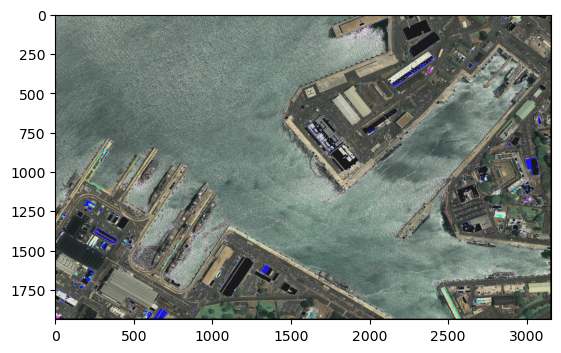

In [21]:
def cox_munk_correction_simp(image, sun_elevation, sensor_zenith, sensor_azimuth):
    """
    Realiza una corrección de glint utilizando una aproximación del modelo de Cox y Munk.
    
    Parámetros:
        image (numpy.ndarray): Matriz que representa la imagen original.
        sun_elevation (float): Ángulo de elevación solar en grados.
        sensor_zenith (float): Ángulo zenital del sensor en grados.
        sensor_azimuth (float): Ángulo azimutal del sensor en grados.
        
    Retorna:
        numpy.ndarray: La imagen corregida de glint.
    """
    # Conversión de grados a radianes
    sun_elevation_rad = np.radians(sun_elevation)
    sensor_zenith_rad = np.radians(sensor_zenith)
    sensor_azimuth_rad = np.radians(sensor_azimuth)
    
    # Parámetros del modelo de Cox y Munk (simplificado)
    R_s = 0.1  # Coeficiente de reflexión especular
    R_d = 0.5  # Coeficiente de reflexión difusa
    
    # Cálculo de la corrección de glint
    cos_theta = np.cos(sensor_zenith_rad)
    cos_phi = np.cos(sensor_azimuth_rad)
    cos_sun_elevation = np.cos(sun_elevation_rad)
    glint_correction = (R_s / cos_theta + R_d / (cos_theta * cos_sun_elevation * cos_phi))
    
    # Aplicar la corrección de glint a la imagen
    corrected_image = image / glint_correction
    
    return corrected_image

ruta_imagen = './mosaic.tif'

with rasterio.open(ruta_imagen) as src:
    R = src.read(1)
    G = src.read(2)
    B = src.read(3)
img = np.stack((R, G, B), axis=-1)

imagen_corregida_munk = gordon_wang_correction_simp(img, sun_elevation, sensor_zenith, sensor_azimuth)

plt.imshow(imagen_corregida_munk.astype(np.uint8))
plt.show()

In [25]:
#display(imagen_corregida_lyzenga,imagen_corregida_gw,imagen_corregida_munk)
print((imagen_corregida_lyzenga == imagen_corregida_munk).all())
print(imagen_corregida_gw == imagen_corregida_munk).all())

False


True